# Static maps

### Download data

Before we start you need to download (and then extract) the dataset zip-package used during this lesson [from this link](https://github.com/Automating-GIS-processes/Lesson-5-Making-Maps/raw/master/data/dataE5.zip).

You should have following Shapefiles in the `dataE5` folder:

  - addresses.shp
  - metro.shp
  - roads.shp
  - some.geojson
  - TravelTimes_to_5975375_RailwayStation.shp
  - Vaestotietoruudukko_2015.shp

Extract the files into a folder called `data`:

```
    $ cd /home/jovyan/work/autogis/notebooks/notebooks/L5
    $ wget https://github.com/Automating-GIS-processes/Lesson-5-Making-Maps/raw/master/data/dataE5.zip
    $ unzip dataE5.zip -d data
```

## Static maps in Geopandas

We have already plotted basic static maps using geopandas during the previous weeks of this course. Remember that when using the [plot() method in geopandas](http://geopandas.org/mapping.html#mapping-tools), we are actually using the tools available from [matplotlib pyplot](https://matplotlib.org/api/pyplot_api.html#pyplot). 

Let's refresh our memory about the basics of plotting maps by creating a static accessibility map with roads and metro line on it (three layers on top of each other in the same figure). Before plotting the layers, we need to check that they are in the same coordinate reference system.

- Read input files:


In [1]:
import geopandas as gpd
from pyproj import CRS
import matplotlib.pyplot as plt
%matplotlib inline

# Filepaths
grid_fp = "data/TravelTimes_to_5975375_RailwayStation.shp"
roads_fp = "data/roads.shp"
metro_fp = "data/metro.shp"

# Read files
grid = gpd.read_file(grid_fp)
roads = gpd.read_file(roads_fp)
metro = gpd.read_file(metro_fp)

<div class="alert alert-info">

**Task**

Check the coordinate reference systems (crs) of the input files. 
In case they are not in the same crs, re-project the layers into a common crs.


</div>

In [2]:
# Check the crs of each layer
print(roads.crs)
print(metro.crs)
print(grid.crs)

epsg:2392
epsg:2392
epsg:3067


In [3]:
# Roads and the metro are in an old Finnish crs, while the grid is in ETRS89 / TM35FIN:
print("Roads crs:", CRS(roads.crs).name)
print("Metro crs:", CRS(metro.crs).name)
print("Grid crs: ",CRS(grid.crs).name)

Roads crs: KKJ / Finland zone 2
Metro crs: KKJ / Finland zone 2
Grid crs:  ETRS89 / TM35FIN(E,N)


In [4]:
# Reproject geometries to ETRS89 / TM35FIN based on the grid crs:
roads = roads.to_crs(crs=grid.crs)
metro = metro.to_crs(crs=grid.crs)

In [5]:
# Now the layers should be in the same crs
roads.crs == metro.crs == grid.crs

True

Once the data are in the same projection, we can plot them on a map.

<div class="alert alert-info">

**Task**

- Make a visualization using the `plot()` -function in Geopandas
- plot first the grid using "quantiles" classification scheme
- then add roads and metro in the same plot

</div>


Plotting options for the polygon: 

- Define the classification scheme using the `scheme` parameter
- Change the colormap using the `cmap` parameter. See [colormap options from matplotlib documentation].(https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html#choosing-colormaps-in-matplotlib)
- You can add a little bit of transparency for the grid using the `alpha` parameter (ranges from 0 to 1 where 0 is fully transparent and 1 has no transparency)

Plotting options fo the lines:

 - adjust color using `color` parameter. See [color options from matplotlib pyplot documentation](https://matplotlib.org/api/pyplot_api.html#matplotlib.pyplot.colors).
 - change `linewidth` if needed

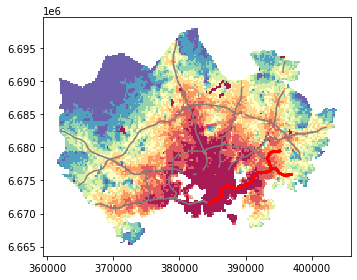

In [6]:
# Visualize the travel times into 9 classes using "Quantiles" classification scheme
my_map = grid.plot(column="car_r_t", linewidth=0.03, cmap="Spectral", scheme="quantiles", k=9, alpha=0.9)

# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=my_map, color="grey", linewidth=1.5)

# Add metro on top of the previous map
metro.plot(ax=my_map, color="red", linewidth=2.5)

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
outfp = "static_map.png"
plt.savefig(outfp, dpi=300)

# Save the figure as svg file
outfp = "static_map.svg"
plt.savefig(outfp, format='svg')

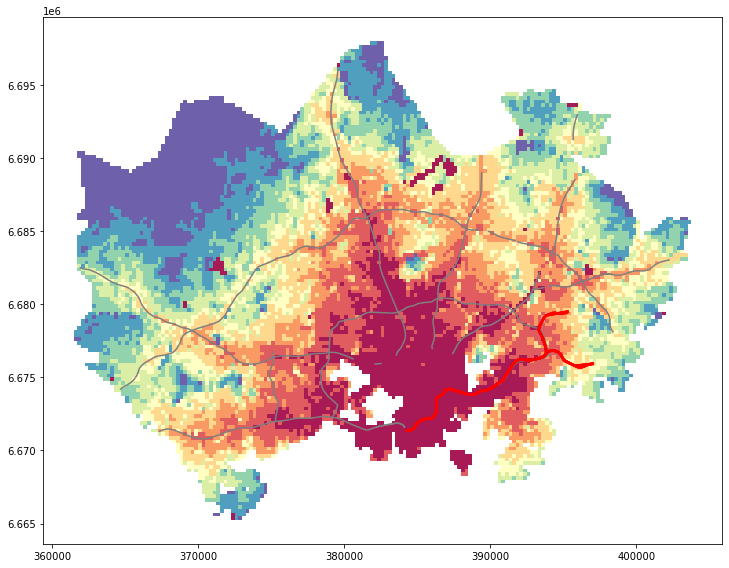

In [17]:
# For better control of the figure and axes, use the plt.subplots function before plotting the layers
# https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html#a-figure-with-just-one-subplot

# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(ax=ax, column="car_r_t", linewidth=0.03, cmap="Spectral", scheme="quantiles", k=9, alpha=0.9)

# Add roads on top of the grid
# (use ax parameter to define the map on top of which the second items are plotted)
roads.plot(ax=ax, color="grey", linewidth=1.5)

# Add metro on top of the previous map
metro.plot(ax=ax, color="red", linewidth=2.5)

# Remove the empty white-space around the axes
plt.tight_layout()

# Save the figure as png file with resolution of 300 dpi
# outfp = "static_map2.png"
# plt.savefig(outfp, dpi=300)

# Adding legend to the plot

<AxesSubplot:>

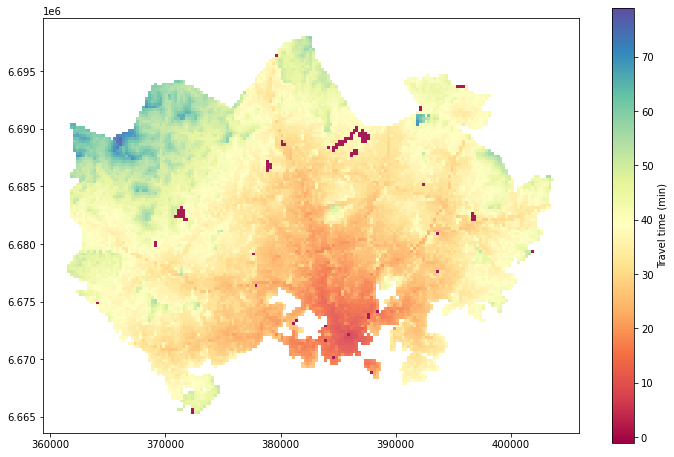

In [16]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Visualize the travel times into 9 classes using "Quantiles" classification scheme
grid.plot(ax=ax, column="car_r_t", cmap="Spectral", alpha=0.9, legend=True, legend_kwds={'label': "Travel time (min)"})

## Adding basemap from external source

It is often useful to add a basemap to your visualization that shows e.g. streets and their names and other useful information directly underneath your visualization. This can be done easily by using ready-made background map tiles that are provided by different providers such as [OpenStreetMap](https://wiki.openstreetmap.org/wiki/Tiles) or [Stamen Design](http://maps.stamen.com). A Python library called [contextily](https://github.com/darribas/contextily) is a handy package that can be used to fetch geospatial raster files and add them to your maps. Map tiles are typically distributed in [Web Mercator projection (EPSG:3857)](http://spatialreference.org/ref/sr-org/epsg3857-wgs84-web-mercator-auxiliary-sphere/), hence **it is often necessary to reproject all the spatial data into** [Web Mercator](https://en.wikipedia.org/wiki/Web_Mercator_projection) before visualizing the data.

In this tutorial, we will see how to add a basemap underneath our previous visualization.

- Read in the travel time data:

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
%matplotlib inline

# Filepaths
grid_fp = "data/TravelTimes_to_5975375_RailwayStation.shp"

# Read data
grid = gpd.read_file(grid_fp)
grid.head(2)

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((382000.000 6697750.000, 381750.000 6..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((382250.000 6697750.000, 382000.000 6..."


- Check the input crs:

In [9]:
grid.crs

<Projected CRS: EPSG:3067>
Name: ETRS89 / TM35FIN(E,N)
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: Finland
- bounds: (19.08, 58.84, 31.59, 70.09)
Coordinate Operation:
- name: TM35FIN
- method: Transverse Mercator
Datum: European Terrestrial Reference System 1989
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

- reproject the layer to ESPG 3857 projection (Web Mercator)

In [10]:
# Reproject to EPSG 3857
data = grid.to_crs(epsg=3857)
data.crs

<Projected CRS: EPSG:3857>
Name: WGS 84 / Pseudo-Mercator
Axis Info [cartesian]:
- X[east]: Easting (metre)
- Y[north]: Northing (metre)
Area of Use:
- name: World - 85°S to 85°N
- bounds: (-180.0, -85.06, 180.0, 85.06)
Coordinate Operation:
- name: Popular Visualisation Pseudo-Mercator
- method: Popular Visualisation Pseudo Mercator
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [11]:
data.head(2)

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,geometry
0,32297,43,32260,48,5785640,32616,116,147,32616,108,139,5975375,32164,459,"POLYGON ((2767221.646 8489079.101, 2766716.966..."
1,32508,43,32471,49,5785641,32822,119,145,32822,111,133,5975375,29547,422,"POLYGON ((2767726.329 8489095.521, 2767221.646..."


Now as we can see, the data has been projected to `epsg:3857`. Also the coordinate values in the `geometry` column have changed.

- Next, we can plot our data using Geopandas and add a basemap for our plot by using a function called `.add_basemap()` from contextily:

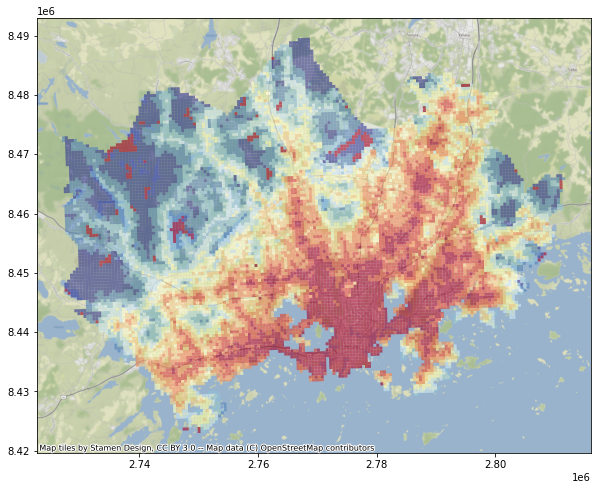

In [19]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Plot the data
data.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap 
ctx.add_basemap(ax)

As we can see, now the map has a background map that is by default using a style `ST_Terrain` fetched from [Stamen Design](http://maps.stamen.com/#terrain). 

However, there are various other possible data sources and styles that can be used. 

- `tile_providers` contain some of the basic url-addresses for different providers and styles that can be used to control the appearence of your background map:

In [13]:
dir(ctx.tile_providers)

['OSM_A',
 'OSM_B',
 'OSM_C',
 'ST_TERRAIN',
 'ST_TERRAIN_BACKGROUND',
 'ST_TERRAIN_LABELS',
 'ST_TERRAIN_LINES',
 'ST_TONER',
 'ST_TONER_BACKGROUND',
 'ST_TONER_HYBRID',
 'ST_TONER_LABELS',
 'ST_TONER_LINES',
 'ST_TONER_LITE',
 'ST_WATERCOLOR',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__']

Here, all the names written in capital letters are the ones that can be used as different basemap styles. All names starting with `ST_` are from Stamen Design, and the `OSM_A` (B and C) are a basic map tile style provided by OpenStreetMap. Notice that the letters A, B, and C are only directing to different tile servers, they are not changing the style. It is also possible to pass other tile providers by passing in the url for the tile provider that you are interested in.

- It is possible to change the tile provider by passing an address to the tile providers' web address using `url` -parameter in `add_basemap()`. Let's see how we can change the style to `OSM_A` which gives us a background map based on OpenStreetMap:

C:\Users\gcolm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The "contextily.tile_providers" module is deprecated and will be removed in contextily v1.1. Please use "contextily.providers" instead.
  
C:\Users\gcolm\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The "url" option is deprecated. Please use the "source" argument instead.
  


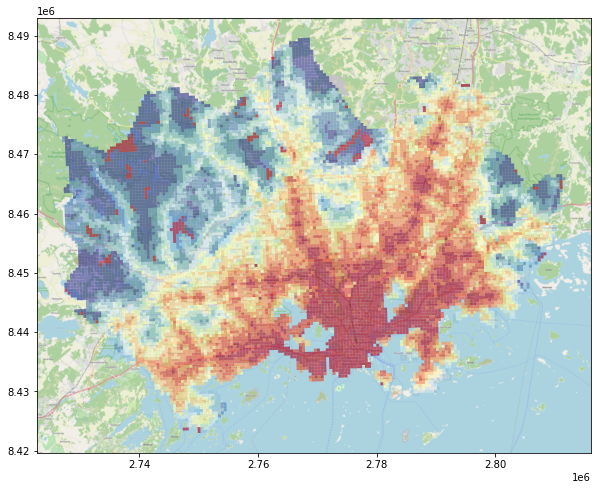

In [20]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Plot the data
data.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap with `ST_TONER` style
ctx.add_basemap(ax, source=ctx.tile_providers.OSM_A)

As we can see, now the background map changed a bit compared to the earlier one as it was fetched from OpenSteetMap. 

- Let's take a subset of our data to see a bit better the background map characteristics. 

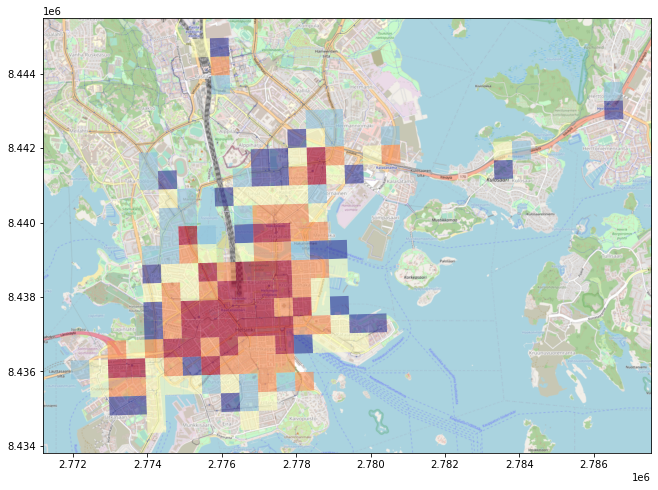

In [26]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Subset the data to seel only grid squares near the destination
subset = data.loc[(data['pt_r_t']>=0) & (data['pt_r_t']<=15)]

# Plot the data from subset
subset.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=5, alpha=0.6)

# Add basemap with `OSM_A` style
ctx.add_basemap(ax, source=ctx.tile_providers._OSM_A)

As we can see now our map has much more details in it as the zoom level of the background map is larger. By default `contextily` sets the zoom level automatically but it is possible to also control that manually using parameter `zoom`. The zoom level is by default specified as `auto` but you can control that by passing in [zoom level](https://wiki.openstreetmap.org/wiki/Zoom_levels) as numbers ranging typically from 1 to 19 (the larger the number, the more details your basemap will have).

- Let's reduce the level of detail from our map by passing `zoom=11`:

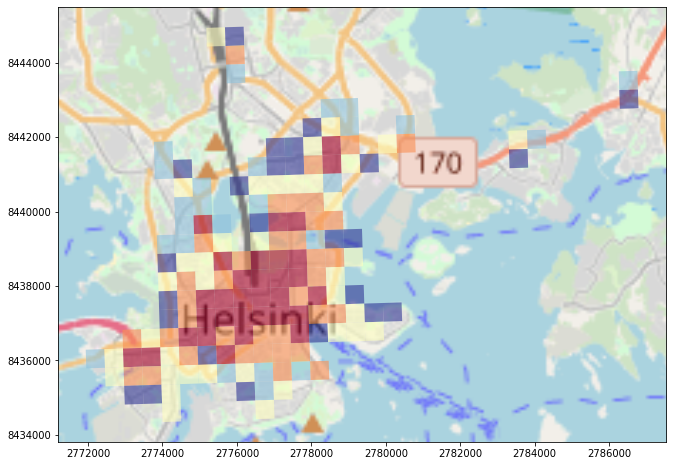

In [16]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Plot the data from subset
subset.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=5, alpha=0.6)

# Add basemap with `OSM_A` style using zoom level of 11
ctx.add_basemap(ax, zoom=11, source=ctx.tile_providers.OSM_A)

As we can see, the map has now less detail.

We can also use `ax.set_xlim()` and `ax.set_ylim()` -parameters to crop our map. The parameters takes as input the coordinates for minimum and maximum on both axis (x and y). We can also change / remove the contribution text by using parameter `attribution`

- Let's plot the original data, and crop the map:

Wall time: 3.3 s


(8430000.0, 8470000.0)

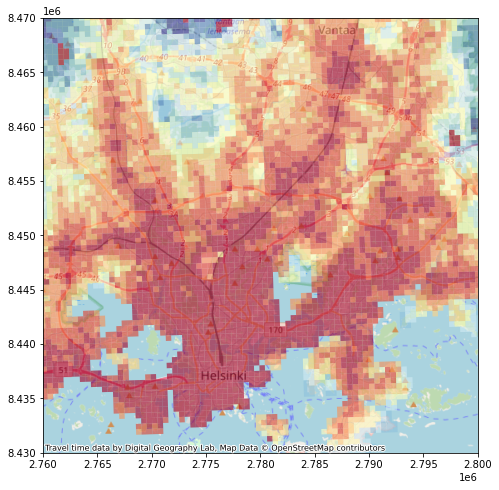

In [30]:
%%time

# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# Plot the data
data.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=9, alpha=0.6)

# Add basemap with `OSM_A` style using zoom level of 11 
# Modify the attribution 
ctx.add_basemap(ax, zoom=11, attribution="Travel time data by Digital Geography Lab, Map Data © OpenStreetMap contributors", source=ctx.tile_providers._OSM_A)

# Crop the figure
ax.set_xlim(2760000, 2800000)
ax.set_ylim(8430000, 8470000)

It is also possible to use many other map tiles from different [Tile Map Services](https://en.m.wikipedia.org/wiki/Tile_Map_Service) as the background map. A good list of different available sources can be found from [here](http://leaflet-extras.github.io/leaflet-providers/preview/). When using map tiles from different sources, it is necessary to parse a url address to the tile provider following a format defined by the provider. 

Next, we will see how to use map tiles provided by CartoDB. To do that we need to parse the url address following their [definition](https://github.com/CartoDB/basemap-styles#1-web-raster-basemaps) `'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{scale}.png'` where:

 - {s}: one of the available subdomains, either [a,b,c,d]
 - {z} : Zoom level. We support from 0 to 20 zoom levels in OSM tiling system.
 - {x},{y}: Tile coordinates in OSM tiling system
 - {scale}: OPTIONAL "@2x" for double resolution tiles
 - {style}: Map style, possible value is one of:
 
    - light_all,
    - dark_all,
    - light_nolabels,
    - light_only_labels,
    - dark_nolabels,
    - dark_only_labels,
    - rastertiles/voyager,
    - rastertiles/voyager_nolabels,
    - rastertiles/voyager_only_labels,
    - rastertiles/voyager_labels_under
    
- We will use this information to parse the parameters in a way that contextily wants them:

(8435000, 8442500)

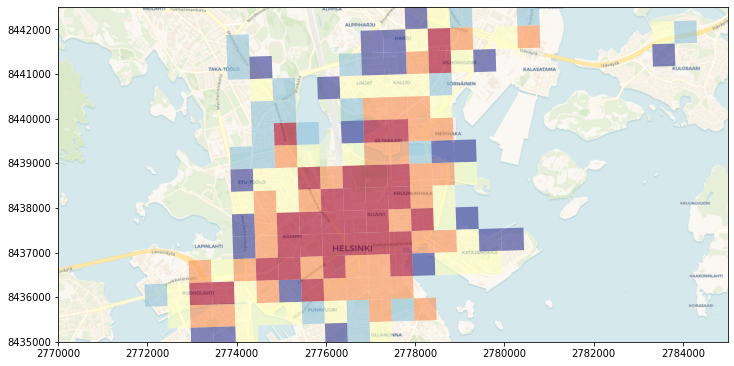

In [18]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# The formatting should follow: 'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{scale}.png'
# Specify the style to use
style = "rastertiles/voyager"
cartodb_url = 'https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png' % style

# Plot the data from subset
subset.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=5, alpha=0.6)
    
# Add basemap with `OSM_A` style using zoom level of 14 
ctx.add_basemap(ax, zoom=14, attribution="", url=cartodb_url)

# Crop the figure
ax.set_xlim(2770000, 2785000)
ax.set_ylim(8435000, 8442500)

As we can see now we have yet again different kind of background map, now coming from CartoDB. 

- Let's make a minor modification and change the style from `"rastertiles/voyager"` to `"dark_all"`:

(8435000, 8442500)

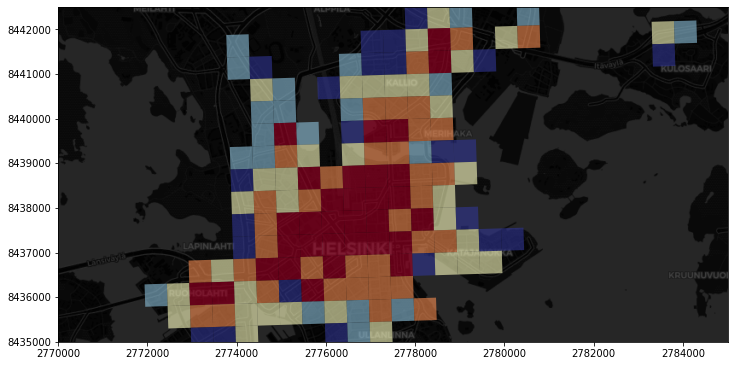

In [19]:
# Control figure size in here
fig, ax = plt.subplots(figsize=(12,8))

# The formatting should follow: 'https://{s}.basemaps.cartocdn.com/{style}/{z}/{x}/{y}{r}.png'
# Specify the style to use
style = "dark_all"
cartodb_url = 'https://a.basemaps.cartocdn.com/%s/{z}/{x}/{y}.png' % style

# Plot the data from subset
subset.plot(ax=ax, column='pt_r_t', cmap='RdYlBu', linewidth=0, scheme="quantiles", k=5, alpha=0.6)

# Add basemap with `OSM_A` style using zoom level of 14 
ctx.add_basemap(ax, zoom=13, attribution="", url=cartodb_url)

# Crop the figure
ax.set_xlim(2770000, 2785000)
ax.set_ylim(8435000, 8442500)

Great! Now we have dark background map fetched from CartoDB. In a similar manner, you can use any map tiles from various other tile providers such as the ones listed in [leaflet-providers](http://leaflet-extras.github.io/leaflet-providers/preview/).